# Titanic. Survived model.

Это легендарное соревнование Titanic ML.

Соревнование простое: используйте машинное обучение, чтобы создать модель, которая предсказывает, какие пассажиры выжили после кораблекрушения Титаника.

[Вся информация здесь](https://www.kaggle.com/competitions/titanic/overview)
<p align="center"><img src='https://i.pinimg.com/originals/1d/99/45/1d99452388883e707eaab82f058828e3.jpg' width="350" height="350"></p>



## Загрузка данных

In [1]:
# импорт необходимых библиотек для работы
import pandas as pd
# import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklift.models import ClassTransformation
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, r2_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

import warnings
warnings.filterwarnings('ignore')

random_state = 42

In [2]:
# загрузка данных
train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')

In [3]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non

(None, None)

In [4]:
train.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [5]:
display(train.head()) 
test.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
display(train.isna().mean())
test.isna().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.205742
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.002392
Cabin       0.782297
Embarked    0.000000
dtype: float64

In [7]:
# приведем названия столбцов к нижнему регистру
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

## Исследовательский анализ

Попробуем описать потрет выжившего в трагедии с Титаником.

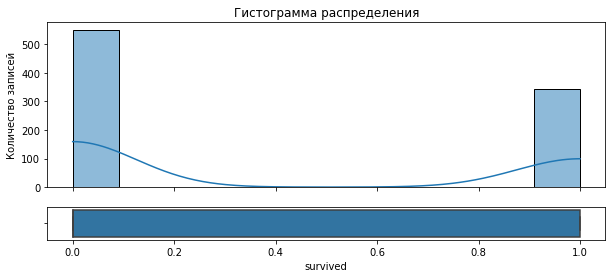

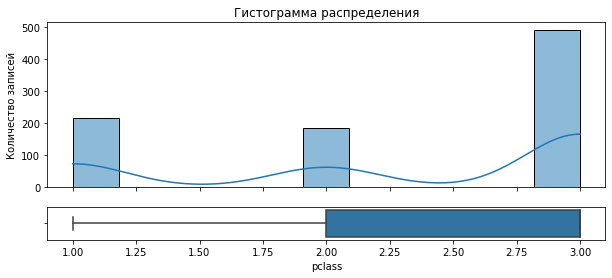

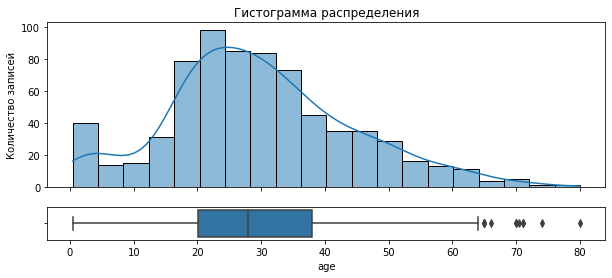

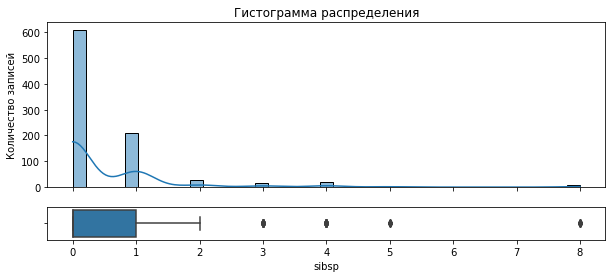

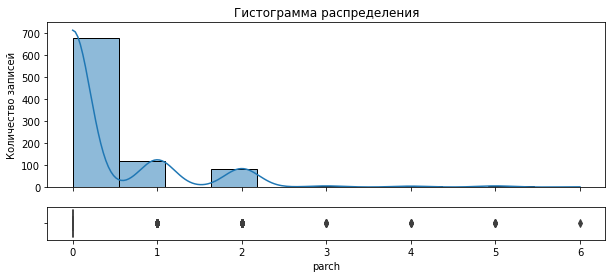

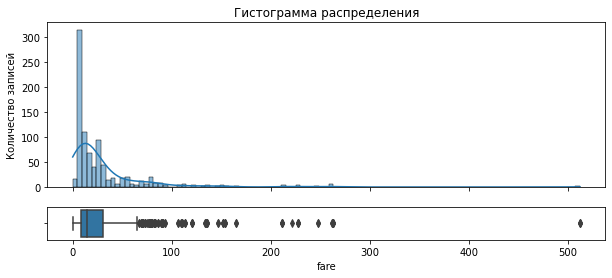

In [8]:
# функция для изучения выбросов и аномалий в данных
def boxplot_table(df, column):
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(10, 4), 
                                         sharex=True,
                                         gridspec_kw=dict(height_ratios=[4,.8]))
    hist = sns.histplot(data=df, x=column, kde=True, ax=axs_hist)
    box = sns.boxplot(data=df, x=column, orient='h', ax=axs_box)
    hist.set(title='Гистограмма распределения',
             ylabel='Количество записей');
# цикл для посьроения графиков по всем полям цифровым
for col in train.select_dtypes(include='number').columns:
    boxplot_table(train, col)

In [9]:
# функция для изучения распределения данных по целевому признаку
def result_table(data, column):
    table = (data.groupby(column)['survived'].agg(['sum', 'count'])
    .assign(share = lambda x: x['sum'] / x['count'])
    ).sort_values(by='share', ascending=False).style.background_gradient(low=0.1, cmap='YlOrRd')
    return table

In [10]:
col = ['pclass', 'sex', 'sibsp', 'parch', 'embarked']
for c in col:
    display(result_table(train, c))

,sum,count,share
pclass,,,
1,136,216,0.629630
2,87,184,0.472826
3,119,491,0.242363


,sum,count,share
sex,,,
female,233,314,0.742038
male,109,577,0.188908


,sum,count,share
sibsp,,,
1,112,209,0.535885
2,13,28,0.464286
0,210,608,0.345395
3,4,16,0.250000
4,3,18,0.166667
5,0,5,0.000000
8,0,7,0.000000


,sum,count,share
parch,,,
3,3,5,0.600000
1,65,118,0.550847
2,40,80,0.500000
0,233,678,0.343658
5,1,5,0.200000
4,0,4,0.000000
6,0,1,0.000000


,sum,count,share
embarked,,,
C,93,168,0.553571
Q,30,77,0.389610
S,217,644,0.336957


In [11]:
# функция для перевода поля в бинарное значение
train['cabin'] = train['cabin'].fillna('NNN')
test['cabin'] = test['cabin'].fillna('NNN')
def cabin_make(row):
    cabin = row['cabin']
    if cabin == 'NNN':
        return 0
    else:
        return 1
# прмиеним функцию    
train['cabin'] = train.apply(cabin_make, axis=1) 
test['cabin'] = test.apply(cabin_make, axis=1) 

In [12]:
result_table(train, 'cabin')

,sum,count,share
cabin,,,
1,136,204,0.666667
0,206,687,0.299854


In [13]:
train.corr().style.background_gradient(low=0.1, cmap='YlOrRd')

,survived,pclass,age,sibsp,parch,fare,cabin
survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.316912
pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.725541
age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.249732
sibsp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.040460
parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.036987
fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.482075
cabin,0.316912,-0.725541,0.249732,-0.040460,0.036987,0.482075,1.000000


In [14]:
train.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S


## Подготовка данных

In [15]:
# функция для замены пропусков в возрасте
def age_fillna(row):
    sex = row['sex']
    pcclass = row['pclass']
    if sex == 'female':
        if pcclass == 1:
            return 34.611765
        elif pcclass == 2:
            return 28.722973
        else:
            return 21.75
            
    elif sex == 'male':
        if pcclass == 1:
            return 41.281386
        elif pcclass == 2:
            return 30.740707
        else:
            return 26.507589

In [16]:
# функция для подготовки сетов
def make_df(table, chek):
    df = table.copy()
    # заменим пропуски
    df['embarked'] = df['embarked'].fillna('N')
    df['age'] = df['age'].fillna(df.apply(age_fillna, axis=1))
    # добавим категорию
#     df['age_cat'] = pd.qcut(df.age, 10, labels=range(1, 11))
    df['title'] = df['name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]
#     сменим тип данных
    for c in df.select_dtypes(include=['object', 'category']).columns:
        df[c] = df[c].astype('category')
        
    # удалим лишние колонки
    X_df = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked', 'title']]
#     X_df = df[['age', 'fare', 'embarked', 'title']]
    if chek == 0:
        y_df = df[['survived']]
        return X_df, y_df
    else:
        return X_df

In [17]:
X_df, y_df = make_df(train, 0)
X_test = make_df(test, 1)

In [18]:
X_test.isna().mean()

pclass      0.000000
sex         0.000000
age         0.000000
sibsp       0.000000
parch       0.000000
fare        0.002392
cabin       0.000000
embarked    0.000000
title       0.000000
dtype: float64

In [19]:
X_test.loc[X_test['fare'].isna(), 'fare'] = X_test.query('pclass == 3 and embarked == "S"')['fare'].mean()

In [20]:
X_df.shape, y_df.shape, X_test.shape

((891, 9), (891, 1), (418, 9))

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=0.25, random_state=random_state)

In [22]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((668, 9), (668, 1), (223, 9), (223, 1))

## Подбор моделей

In [23]:
models_results = {
            'model': [],
            'best_score': [],
            'accurasy': [],
            'f1': [],
            'rocauc': [],
            'precision': []
        }

In [24]:
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=random_state)

### Catboost

In [25]:
cat_features = list(X_train.select_dtypes(include=['object', 'category']).columns)
cat_features.append('cabin')

In [26]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced'
                               , classes=np.unique(y_train['survived'])
                               , y=y_train['survived'])
class_weights = dict(zip(np.unique(y_train['survived']), weights))

In [27]:
# подберем гипперпарметры для модели
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = 100)
cbc = CatBoostClassifier(random_state=random_state
                         , cat_features=cat_features
                         , class_weights=class_weights
#                         , auto_class_weights='Balanced'
                        , eval_metric='Accuracy')
parameters = {'depth': range(4,17,4),
              'learning_rate': [.01, .1],
              'iterations': range(50,501,50),
              'l2_leaf_reg': range(2,7,2)
             }

grid_cbc = RandomizedSearchCV(cbc, parameters, scoring='accuracy', cv=cv)
grid_cbc.fit(X_train, y_train, **fit_params)

0:	learn: 0.8076319	test: 0.7872994	test1: 0.7805384	best: 0.7805384 (0)	total: 222ms	remaining: 44.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8029701991
bestIteration = 6

Shrink model to first 7 iterations.
0:	learn: 0.7996407	test: 0.7992000	test1: 0.7801008	best: 0.7801008 (0)	total: 46.1ms	remaining: 9.17s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.824399678
bestIteration = 4

Shrink model to first 5 iterations.
0:	learn: 0.8204134	test: 0.8156436	test1: 0.7721106	best: 0.7721106 (0)	total: 30.9ms	remaining: 6.15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8016855598
bestIteration = 20

Shrink model to first 21 iterations.
0:	learn: 0.8014564	test: 0.7932711	test1: 0.7785338	best: 0.7785338 (0)	total: 23.1ms	remaining: 4.61s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7993986193
bestIteration = 20

Shrink model to first 21 iterations.
0:	learn: 0.8027339	test: 0.7932711	test1: 0.7

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001DCF581A8E0>,
                   param_distributions={'depth': range(4, 17, 4),
                                        'iterations': range(50, 501, 50),
                                        'l2_leaf_reg': range(2, 7, 2),
                                        'learning_rate': [0.01, 0.1]},
                   scoring='accuracy')

In [28]:
best_cbc = grid_cbc.best_estimator_
grid_cbc.best_score_, grid_cbc.best_params_

(0.8407185628742514,
 {'learning_rate': 0.01, 'l2_leaf_reg': 6, 'iterations': 300, 'depth': 16})

In [29]:
best_cbc.fit(X_train, y_train)

pred = best_cbc.predict(X_val)
predict = best_cbc.predict_proba(X_val)[:, 1]

0:	learn: 0.7813801	total: 10.5ms	remaining: 3.14s
1:	learn: 0.8040716	total: 23.5ms	remaining: 3.49s
2:	learn: 0.8083623	total: 31.8ms	remaining: 3.15s
3:	learn: 0.8089861	total: 39.4ms	remaining: 2.91s
4:	learn: 0.8243631	total: 625ms	remaining: 36.9s
5:	learn: 0.8298586	total: 643ms	remaining: 31.5s
6:	learn: 0.8282204	total: 653ms	remaining: 27.3s
7:	learn: 0.8306300	total: 1.17s	remaining: 42.8s
8:	learn: 0.8301967	total: 1.2s	remaining: 38.7s
9:	learn: 0.8301967	total: 1.21s	remaining: 35.1s
10:	learn: 0.8326063	total: 1.23s	remaining: 32.3s
11:	learn: 0.8241726	total: 1.24s	remaining: 29.7s
12:	learn: 0.8314015	total: 1.32s	remaining: 29.2s
13:	learn: 0.8314015	total: 1.94s	remaining: 39.6s
14:	learn: 0.8350160	total: 2.54s	remaining: 48.2s
15:	learn: 0.8326063	total: 2.55s	remaining: 45.3s
16:	learn: 0.8314015	total: 2.57s	remaining: 42.8s
17:	learn: 0.8314015	total: 2.6s	remaining: 40.7s
18:	learn: 0.8314015	total: 2.63s	remaining: 38.9s
19:	learn: 0.8314015	total: 2.63s	remai

In [30]:
from catboost.utils import get_roc_curve, select_threshold

catboost_pool = Pool(X_train, y_train, cat_features=cat_features)
roc_curve_values = get_roc_curve(best_cbc, catboost_pool)

best_score = 0
it = 0
best_boundary = 0

for i in range(1, 100, 1):
    boundary = select_threshold(best_cbc, 
                            curve=roc_curve_values,  
                            FPR=i/100)
    predicted = (predict >= boundary)*1
    if accuracy_score(predicted, y_val) > best_score:
        best_score = accuracy_score(predicted, y_val)
        it = i
        best_boundary = boundary

best_score, it, best_boundary

(0.8295964125560538, 4, 0.6601944894003775)

In [31]:
predicted = (predict >= best_boundary)*1

In [32]:
accuracy_score(pred, y_val), accuracy_score(predicted, y_val)

(0.7937219730941704, 0.8295964125560538)

In [33]:
precision_score(pred, y_val), precision_score(predicted, y_val)

(0.7640449438202247, 0.7303370786516854)

In [34]:
predicted.mean()

0.3542600896860987

In [35]:
models_results['model'].append(grid_cbc.best_estimator_)
models_results['best_score'].append(grid_cbc.best_score_)
models_results['accurasy'].append(accuracy_score(predicted, y_val))
models_results['f1'].append(f1_score(predicted, y_val))
models_results['rocauc'].append(roc_auc_score(predicted, y_val))
models_results['precision'].append(precision_score(predicted, y_val))

In [36]:
cbc = pd.DataFrame({
    'feature_name': best_cbc.feature_names_,
    'feature_score': best_cbc.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cbc.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,title,25.062612
1,pclass,18.461126
2,sex,14.795012
3,fare,10.482184
4,embarked,10.334518
5,age,7.497963
6,cabin,5.744159
7,sibsp,5.089287
8,parch,2.533140


### LGBM

In [37]:
fit_params = dict(early_stopping_rounds = 100,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  eval_metric = 'Accuracy',
                  verbose = 100)
params = {'n_estimators': range(20, 1001, 20),
          'learning_rate': [0.005, 0.01, 0.1],
          'max_depth': range(-1, 36, 1),
          'num_leaves': range(1, 200, 1),
          'boosting_type': ['gbdt', 'dart', 'goss']       
         }
lgbm = LGBMClassifier(random_state=random_state, class_weight='balanced')
grid_lgbm = RandomizedSearchCV(lgbm, params, scoring='accuracy', cv=cv)
grid_lgbm.fit(X_train, y_train, **fit_params)

[100]	valid_0's binary_logloss: 0.537147	valid_1's binary_logloss: 0.549947
[200]	valid_0's binary_logloss: 0.457822	valid_1's binary_logloss: 0.487357
[300]	valid_0's binary_logloss: 0.409091	valid_1's binary_logloss: 0.454519
[400]	valid_0's binary_logloss: 0.380746	valid_1's binary_logloss: 0.443671
[100]	valid_0's binary_logloss: 0.540804	valid_1's binary_logloss: 0.553479
[200]	valid_0's binary_logloss: 0.461731	valid_1's binary_logloss: 0.492756
[300]	valid_0's binary_logloss: 0.414046	valid_1's binary_logloss: 0.460727
[400]	valid_0's binary_logloss: 0.384485	valid_1's binary_logloss: 0.444348
[100]	valid_0's binary_logloss: 0.53044	valid_1's binary_logloss: 0.555288
[200]	valid_0's binary_logloss: 0.450912	valid_1's binary_logloss: 0.490125
[300]	valid_0's binary_logloss: 0.404389	valid_1's binary_logloss: 0.465703
[400]	valid_0's binary_logloss: 0.379162	valid_1's binary_logloss: 0.45621
[100]	valid_0's binary_logloss: 0.537409	valid_1's binary_logloss: 0.550182
[200]	valid_0'

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=42),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'learning_rate': [0.005, 0.01, 0.1],
                                        'max_depth': range(-1, 36),
                                        'n_estimators': range(20, 1001, 20),
                                        'num_leaves': range(1, 200)},
                   scoring='accuracy')

In [38]:
best_lgbm = grid_lgbm.best_estimator_
grid_lgbm.best_score_, grid_lgbm.best_params_

(0.8395209580838323,
 {'num_leaves': 171,
  'n_estimators': 640,
  'max_depth': 22,
  'learning_rate': 0.1,
  'boosting_type': 'goss'})

In [39]:
best_lgbm.fit(X_train, y_train)
pred = best_lgbm.predict(X_val)

In [40]:
models_results['model'].append(grid_lgbm.best_estimator_)
models_results['best_score'].append(grid_lgbm.best_score_)
models_results['accurasy'].append(accuracy_score(pred, y_val))
models_results['f1'].append(f1_score(pred, y_val))
models_results['rocauc'].append(roc_auc_score(pred, y_val))
models_results['precision'].append(precision_score(pred, y_val))

In [41]:
lgb = pd.DataFrame({
    'feature_name': best_lgbm.feature_name_,
    'feature_score': best_lgbm.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

lgb.style.background_gradient(low=0.1, cmap='YlOrRd')

,feature_name,feature_score
0,fare,1862
1,age,1601
2,embarked,254
3,sex,235
4,sibsp,182
5,pclass,172
6,parch,104
7,cabin,99
8,title,1


### RandomForestClassifier

In [42]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
PassengerId,,,,,,,,,
299,1,male,41.281386,0,0,30.5000,1,S,Mr
885,3,male,25.000000,0,0,7.0500,0,S,Mr
248,2,female,24.000000,0,2,14.5000,0,S,Mrs
479,3,male,22.000000,0,0,7.5208,0,S,Mr
306,1,male,0.920000,1,2,151.5500,1,S,Master


In [43]:
X_train = pd.get_dummies(X_train, columns=['sex', 'embarked', 'title'], drop_first= True)
X_val = pd.get_dummies(X_val, columns=['sex', 'embarked', 'title'], drop_first= True)
X_test = pd.get_dummies(X_test, columns=['sex', 'embarked', 'title'], drop_first= True)
X_df = pd.get_dummies(X_df, columns=['sex', 'embarked', 'title'], drop_first= True)
X_train.shape, X_val.shape, X_test.shape, X_df.shape

((668, 26), (223, 26), (418, 17), (891, 26))

In [44]:
for c in list(set(X_df.columns) - set(X_test.columns)):
    X_test[c] = 0
X_test = X_test.drop('title_ Dona', axis=1)
X_train.shape, X_val.shape, X_test.shape, X_df.shape

((668, 26), (223, 26), (418, 26), (891, 26))

In [45]:
ss = StandardScaler() 
X_train = ss.fit_transform(X_train) 
X_val = ss.fit_transform(X_val) 
X_test = ss.fit_transform(X_test) 
X_df = ss.fit_transform(X_df)

In [46]:
rfc = RandomForestClassifier(random_state=random_state, class_weight='balanced')

params = {'n_estimators': range(100, 1001, 100),
          'max_depth': range(1, 24, 1),
          'min_samples_split': range(1,10,1),
          'min_samples_leaf': range(1,10,1),
          'verbose': [100]
         }

grid_cv = RandomizedSearchCV(rfc, params, scoring='neg_log_loss', cv=cv)
grid_cv.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 400
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
building tree 2 of 400
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
building tree 3 of 400
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
building tree 4 of 400
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
building tree 5 of 400
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
building tree 6 of 400
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
building tree 7 of 400
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
building tree 8 of 400
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
building tree 9 of 400
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining: 

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   param_distributions={'max_depth': range(1, 24),
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(1, 10),
                                        'n_estimators': range(100, 1001, 100),
                                        'verbose': [100]},
                   scoring='neg_log_loss')

In [47]:
best_rfc = grid_cv.best_estimator_
grid_cv.best_score_, grid_cv.best_params_

(-0.4036212844184307,
 {'verbose': 100,
  'n_estimators': 400,
  'min_samples_split': 7,
  'min_samples_leaf': 1,
  'max_depth': 11})

In [48]:
best_rfc.fit(X_train, y_train)
pred = best_rfc.predict(X_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 400
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
building tree 2 of 400
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
building tree 3 of 400
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
building tree 4 of 400
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
building tree 5 of 400
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
building tree 6 of 400
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
building tree 7 of 400
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
building tree 8 of 400
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
building tree 9 of 400
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining: 

In [49]:
accuracy_score(pred, y_val), f1_score(pred, y_val), roc_auc_score(pred, y_val), precision_score(pred, y_val)

(0.7982062780269058, 0.736842105263158, 0.7919477599031309, 0.7078651685393258)

In [50]:
models_results['model'].append('best_rfc')
models_results['best_score'].append(grid_cv.best_score_)
models_results['accurasy'].append(accuracy_score(pred, y_val))
models_results['f1'].append(f1_score(pred, y_val))
models_results['rocauc'].append(roc_auc_score(pred, y_val))
models_results['precision'].append(precision_score(pred, y_val))

## Тестирование

In [51]:
pd.DataFrame(data=models_results).sort_values('accurasy', ascending=False)

,model,best_score,accurasy,f1,rocauc,precision
0,<catboost.core.CatBoostClassifier object at 0x...,0.840719,0.829596,0.773810,0.828059,0.730337
2,best_rfc,-0.403621,0.798206,0.736842,0.791948,0.707865
1,"LGBMClassifier(boosting_type='goss', class_wei...",0.839521,0.771300,0.732984,0.764625,0.786517


In [52]:
X_df, y_df = make_df(train, 0)
X_test = make_df(test, 1)
X_test.loc[X_test['fare'].isna(), 'fare'] = X_test.query('pclass == 3 and embarked == "S"')['fare'].mean()
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=0.25, random_state=random_state)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((668, 9), (668, 1), (223, 9), (223, 1))

In [53]:
# обучим модель на всех данных
best_cbc.fit(X_df, y_df)
# сделаем предсказания на тестовых данных
predicted = (best_cbc.predict_proba(X_test)[:, 1] >= best_boundary)*1
submission = pd.read_csv('gender_submission.csv')

0:	learn: 0.7718204	total: 6.77ms	remaining: 2.02s
1:	learn: 0.7840770	total: 14.8ms	remaining: 2.21s
2:	learn: 0.7920428	total: 20.6ms	remaining: 2.03s
3:	learn: 0.7985308	total: 44.8ms	remaining: 3.32s
4:	learn: 0.8118699	total: 66.7ms	remaining: 3.94s
5:	learn: 0.8109690	total: 87.4ms	remaining: 4.28s
6:	learn: 0.8213847	total: 113ms	remaining: 4.72s
7:	learn: 0.8061013	total: 118ms	remaining: 4.3s
8:	learn: 0.8081559	total: 142ms	remaining: 4.58s
9:	learn: 0.8106058	total: 152ms	remaining: 4.4s
10:	learn: 0.8102818	total: 162ms	remaining: 4.26s
11:	learn: 0.8147863	total: 798ms	remaining: 19.1s
12:	learn: 0.8120836	total: 809ms	remaining: 17.9s
13:	learn: 0.8209503	total: 1.45s	remaining: 29.6s
14:	learn: 0.8224280	total: 1.47s	remaining: 28s
15:	learn: 0.8209503	total: 1.49s	remaining: 26.4s
16:	learn: 0.8224280	total: 1.5s	remaining: 24.9s
17:	learn: 0.8230049	total: 1.55s	remaining: 24.3s
18:	learn: 0.8244827	total: 1.57s	remaining: 23.2s
19:	learn: 0.8274382	total: 1.59s	remain

In [54]:
submission['Survived'] = predicted
# submission['Survived'] = submission['Survived'].astype('int')
submission.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv').head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [55]:
!head -n 5 submission.csv

"head" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.
